In [1]:
import os
import os.path as op

import numpy as np
from scipy.stats import pearsonr

import nibabel as nib
from nilearn import datasets, image

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpecFromSubplotSpec
from matplotlib.colors import LinearSegmentedColormap
from seaborn import kdeplot

import importlib

import dgsp
import bimod_plots as plot

## Loading Brain Data

In [2]:
# CopyPasted from utils.py in other repo:
import pickle

def save(pickle_filename: str, iterable: object) -> None:
    """
    Pickle an object to a file.

    Parameters
    ----------
    pickle_filename : str
        Path to the file where the object will be pickled.
    iterable : object
        The object to be pickled.

    Returns
    -------
    None
    """
    with open(pickle_filename, "wb") as handle:
        pickle.dump(iterable, handle, protocol=pickle.HIGHEST_PROTOCOL)


def load(pickle_filename: str) -> object:
    """
    Load a pickled object from the specified file.

    Parameters
    ----------
    pickle_filename : str
        The filename of the pickled object to load.

    Returns
    -------
    object
        The loaded object.
    """
    with open(pickle_filename, "rb") as handle:
        b = pickle.load(handle)
    return b

In [17]:
path_to_data = "./data/brain"

# Could be 50, 100, 200, 400
delay_max = 100
#delay_max = 100
scale = 1

undirected = True

filename = f"bundle_probability_atlas-scale{scale}.pkl"

bundle_prob = load(op.join(path_to_data, filename))
bundle_prob = bundle_prob[:-2][:, :-2]
bundle_prob -= np.diag(np.diag(bundle_prob))
ftract_prob = load(op.join(path_to_data, f"adj_probability_ftract-d{delay_max}-scale{scale}.pkl"))
ftract_prob = ftract_prob[:-2][:, :-2]

print(bundle_prob.shape)
print(ftract_prob.shape)

node_centers = load(op.join(path_to_data, f"roi_centers-ftract-scale{scale}.pkl"))[:82]

scale_to_nroi = {1:"33", 2:"60", 3:"125"}

labels = np.genfromtxt(op.join(path_to_data, f"brain_labels.csv"), dtype=str)

print(f"There are {len(labels)} nodes in the graph")
all_types = ["lh", "rh", "lhsc", "rhsc"]
types_rename = ["Left", "Right", "Left-sub", "Right-sub"]
type2num = {t:i for i, t in enumerate(all_types)}

node_type = [type2num[lab.split("-")[0]] for lab in labels]

k_threshold = 1
for k_threshold in np.arange(0, 1, 0.1):
    # k_threshold = 0

    k_matrix = (2 * bundle_prob * ftract_prob)/(ftract_prob + ftract_prob.T)

    k_matrix = np.nan_to_num(k_matrix)

    zorder=1
    ls = "-o"
    if k_threshold > 0:
        zorder=0
        ls = "-"
        k_matrix = (k_matrix >= k_threshold).astype(int)

    k_matrix -= np.diag(np.diag(k_matrix))

    ## UNCOMMENT BELOW FOR UNDIRECTED
#     k_matrix = (bundle_prob.copy() > k_threshold).astype(int)

#     _, S, _ = dgsp.sorted_SVD(dgsp.modularity_matrix(k_matrix))
#     plt.plot(S[:10], "-o", label=f"t={k_threshold:1.2f}")

k_threshold = 0.8

if undirected:
    k_matrix = (bundle_prob.copy() > k_threshold).astype(int)
else:
    k_matrix = (k_matrix >= k_threshold).astype(int)

print("Is it undirected ?", np.allclose(k_matrix, k_matrix.T))

## UNCOMMENT BELOW FOR SINGULAR VALUES SPECTRUM
# _, S, _ = dgsp.sorted_SVD(dgsp.modularity_matrix(k_matrix))
# plt.plot(S[:10], "-o", label=f"Selected", color="k", lw=2, zorder=2)

# plt.legend()

(82, 82)
(82, 82)
There are 82 nodes in the graph
Is it undirected ? True


/var/folders/nj/ltrlv15x5jj2jq78pbb2srz80000gn/T/ipykernel_14937/1610897002.py:38: RuntimeWarning: invalid value encountered in divide
  k_matrix = (2 * bundle_prob * ftract_prob)/(ftract_prob + ftract_prob.T)


In [18]:
sch_atlas = datasets.fetch_atlas_schaefer_2018(n_rois=1000, yeo_networks=7)

atlas_file = sch_atlas.maps
atlas_img = nib.load(atlas_file)
atlas_data = atlas_img.get_fdata().astype(int)

path_to_ftract_atlas = op.join(path_to_data, f"roi_atlas-ftract-scale1-GM.nii.gz")
laus_img = nib.load(path_to_ftract_atlas)

laus_in_sch = image.resample_to_img(laus_img, atlas_img, interpolation="nearest")
laus_data = laus_in_sch.get_fdata().astype(int)

all_networks = np.unique([lab.split("_")[2] for lab in sch_atlas.labels.astype(str)])

all_nodal_net = np.zeros((len(all_networks), len(k_matrix)))
for net_id, selected_net in enumerate(all_networks):
        is_dmn = [selected_net in lab for lab in sch_atlas.labels.astype(str)]
        dmn_ids = np.where(is_dmn)[0]
        dmn_data = np.isin(atlas_data, dmn_ids+1).astype(int)
        all_nodal_net[net_id] = np.array([np.mean(dmn_data[laus_data == i]) for i in range(1, laus_data.max() + 1)])

In [19]:
importlib.reload(dgsp)
import seaborn as sns

graph = k_matrix.copy()

posx = 0
posy = 1
posz = 2
edge_alpha = 0.4
write_letter = True
vmax = 0.6
annot = True

graph_pos = {i: (x, y) for i, (x, y) in enumerate(zip(node_centers[:, posx], node_centers[:, posy]))}

U, S, Vh = dgsp.sorted_SVD(dgsp.modularity_matrix(graph))
V = Vh.T

n_nodes = len(S)

vec_id = 0

n_vec_max = 2
n_kmeans = 12

C_mat_out, c_pinv_out, C_mat_in, c_pinv_in, bimod_idx = dgsp.get_c_pinv(graph, n_vec_max, n_kmeans, normalize=False)

In [20]:
n_trials = 4

all_rec_from = np.zeros((n_trials, all_nodal_net.shape[0], all_nodal_net.shape[1]))
all_rec_to = np.zeros_like(all_rec_from)
all_rses = np.zeros((n_trials, len(all_networks)))
all_rses_to = np.zeros((n_trials, len(all_networks)))
corr_mat = np.zeros((n_trials+1, len(all_networks), len(all_networks)))
corr_mat_to = np.zeros((n_trials+1, len(all_networks), len(all_networks)))

# for i in range(n_trials):
#     coefs_in = c_pinv_in @ x_hat_source
#     x_hat_source = C_mat_out @ coefs_in

#     all_rec[i] = x_hat_source
#     all_corr[i] = pearsonr(x_hat_source, xt)[0]

for net_i, selected_net in enumerate(all_nodal_net):
    xt = selected_net

    for j, net in enumerate(all_nodal_net):
        corr_mat[0, net_i, j] = pearsonr(net, selected_net)[0]
        corr_mat_to[0, net_i, j] = corr_mat[0, net_i, j]

    last_rec = xt.copy()
    last_rec_to = xt.copy()
    for i in range(n_trials):
        coefs_in = c_pinv_in @ last_rec
        coefs_out = c_pinv_out @ last_rec_to
        all_rec_from[i, net_i] = C_mat_out @ coefs_in
        all_rec_to[i, net_i] = C_mat_in @ coefs_out

        last_rec = all_rec_from[i, net_i]
        last_rec_to = all_rec_from[i, net_i]

        all_rses[i, net_i] = np.linalg.norm(all_rec_from[i, net_i] - xt)/np.linalg.norm(xt)
        all_rses_to[i, net_i] = np.linalg.norm(all_rec_to[i, net_i] - xt)/np.linalg.norm(xt)

        for j, net in enumerate(all_nodal_net):
            corr_mat[i+1, net_i, j] = pearsonr(net, all_rec_from[i, net_i])[0]
            corr_mat_to[i+1, j, net_i] = pearsonr(net, all_rec_to[i, net_i])[0]

Text(243.9240485902862, 0.5, 'Network Signal')

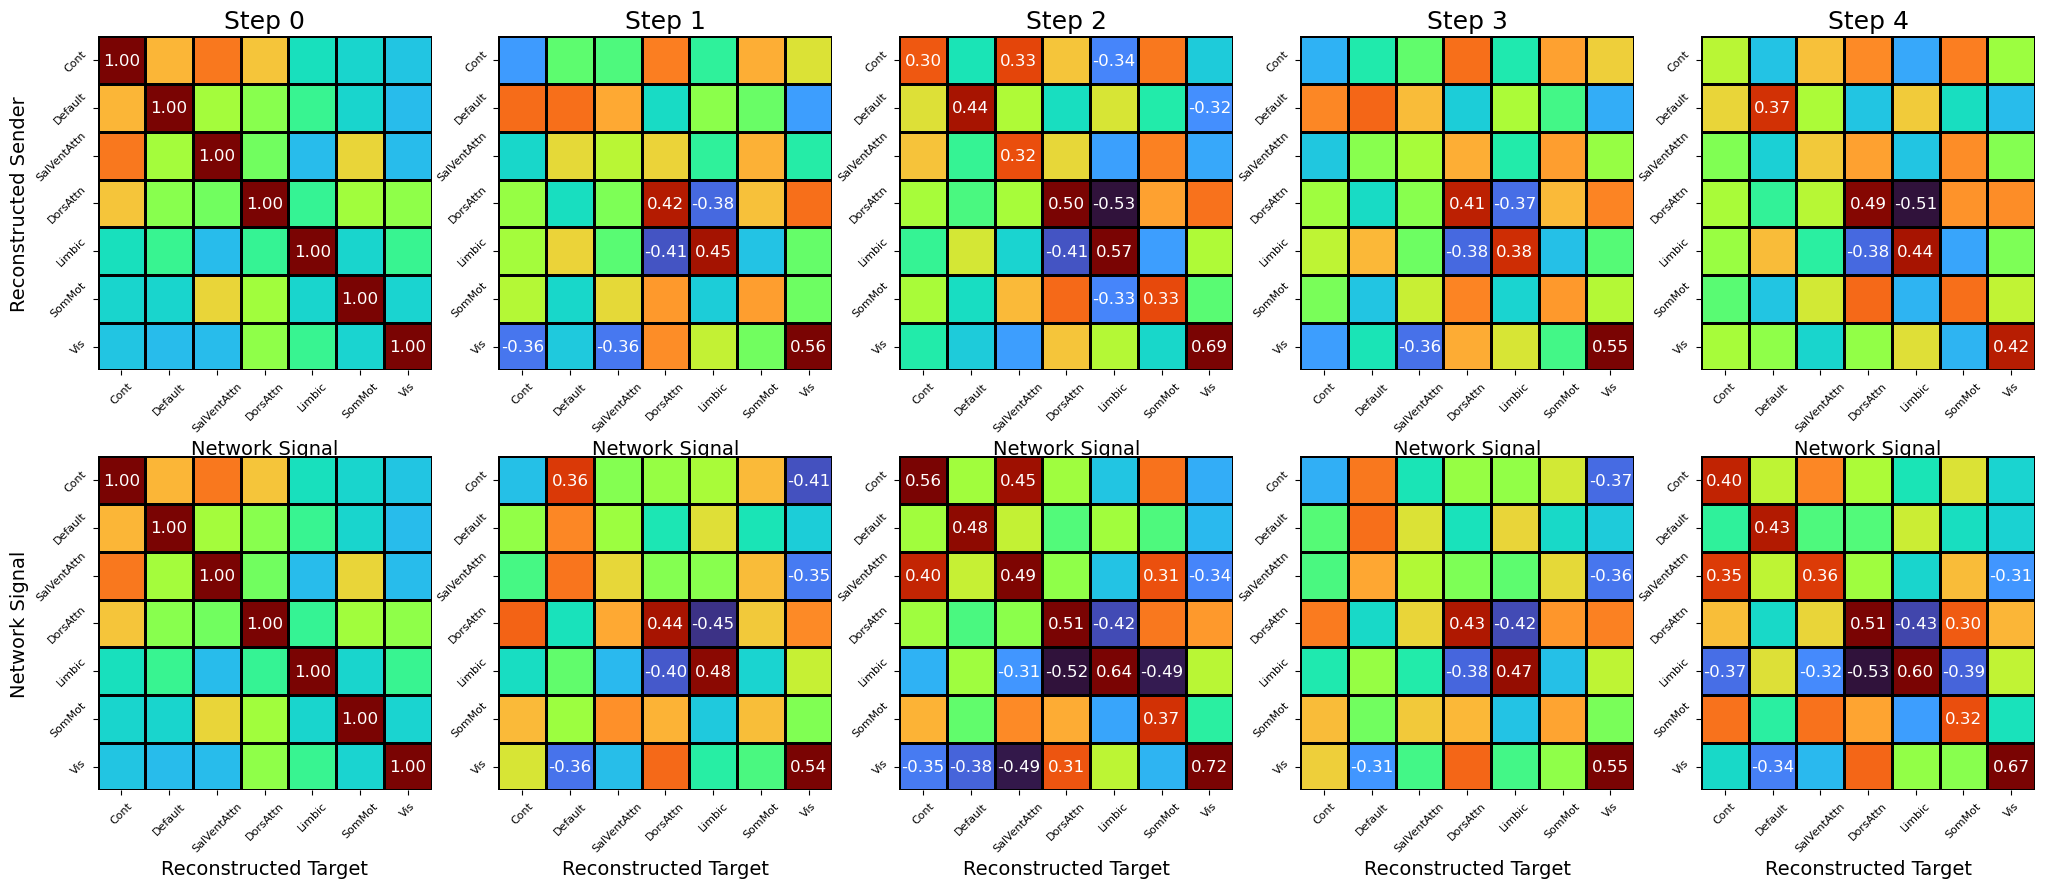

In [21]:
fig, all_axes = plt.subplots(nrows=2, ncols=len(corr_mat), figsize=(len(corr_mat)*5, 10), gridspec_kw={"wspace": 0.2})

thresh = 0.3

manual_sort = [0, 1, 4, 2, 3, 5, 6]

for i, corr in enumerate(corr_mat):
    # sns.heatmap(corr, ax=axes[i], annot=True, cmap="turbo", vmin=-0.5, vmax=0.5)

    for axes, mat in zip(all_axes, [corr, corr_mat_to[i]]):
        axes[i] = sns.heatmap(mat[manual_sort][:, manual_sort], cmap="turbo", ax=axes[i], square=True, cbar=False,
                            vmin=-0.5, vmax=0.5, linewidths=1, linecolor="k")#, cbar_kws={"shrink": 0.8, "pad": 0.01})
        axes[i].set_xticklabels([lab for lab in all_networks[manual_sort]], fontsize=8, rotation=45)
        axes[i].set_yticklabels([lab for lab in all_networks[manual_sort]], fontsize=8, rotation=45)


        for r, row in enumerate(mat[manual_sort][:, manual_sort]):
            for j, val in enumerate(row):
                if np.abs(val) >= thresh:
                    axes[i].text(j+0.5, r+0.5, f"{val:1.2f}", ha="center", va="center", fontsize=12, color="w")#, weight="semibold")

    all_axes[0, i].set_title(f"Step {i}", fontsize=18)
    all_axes[0, i].set_xlabel("Network Signal", fontsize=14)
    all_axes[1, i].set_xlabel("Reconstructed Target", fontsize=14)

all_axes[0, 0].set_ylabel("Reconstructed Sender", fontsize=14)
all_axes[1, 0].set_ylabel("Network Signal", fontsize=14)

## Actual fMRI data

@Deb: I put this data on the server so that you can access it easily (in the same format at `miplab-nas2/Data3/Alex/HCP-Graph/Laus2008_smth6_lp0.15`)

(1200, 82)


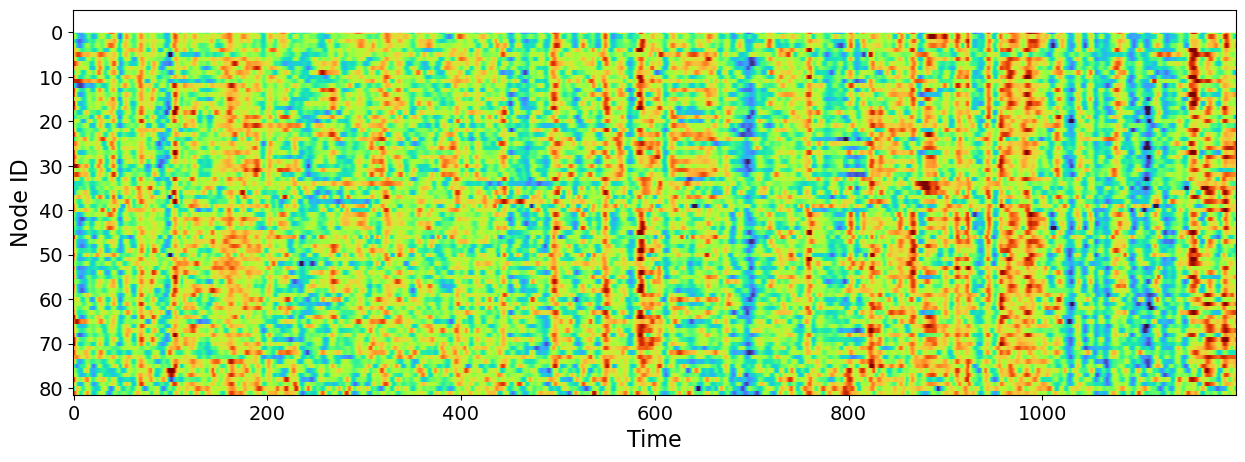

In [30]:
path_to_all_fmri = "/Users/acionca/data/HCP-MIP/Laus2008_smth6_lp0.15"
# sub-100307_task-rest_dir-LR_timeseries.csv
# sub-100307_task-motor_dir-LR_timeseries.csv

sub = 100307
# task = "motor"
task = "rest1"
# task = "emotion"
# task = "gambling"
# task = "language"
fname = f"sub-{sub}_task-{task}_dir-LR_timeseries.csv"

path_to_fmri = op.join(path_to_all_fmri, fname)
nodal_fmri = np.genfromtxt(path_to_fmri, delimiter=",")

print(nodal_fmri.shape)
ntimepoints = len(nodal_fmri)

maxval = np.max(np.abs(nodal_fmri))*0.7

if "rest" not in task:
    path_to_paradygm = op.join(path_to_all_fmri, fname.replace("timeseries", "regressor"))
    paradygm = np.genfromtxt(path_to_paradygm, delimiter=",").astype(int)
else:
    paradygm = np.zeros(ntimepoints, dtype=int)

fig, axes = plt.subplots(figsize=(15, 5))

axes.imshow(nodal_fmri.T, aspect="auto", cmap="turbo", vmin=-maxval, vmax=maxval, interpolation="none")

# for para_val in np.unique(paradygm):
maxval = paradygm.max()


if "rest" not in task:
    para_colors = [plt.get_cmap("Set1")(i) for i in range(maxval)]
    para_cmap = LinearSegmentedColormap.from_list("", ["silver"] + para_colors,)
else:
    para_cmap = "binary"

axes.scatter(np.arange(len(paradygm)), [-1]*len(paradygm), s=20, marker="s",
             c=paradygm, cmap=para_cmap)

axes.set_ylabel("Node ID", fontsize=16)
axes.set_xlabel("Time", fontsize=16)
axes.tick_params(labelsize=14)

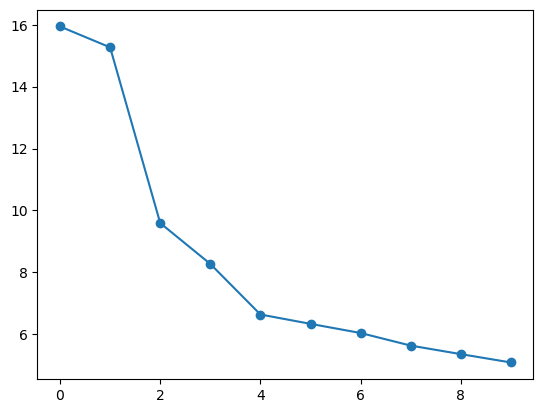

In [31]:
U, S, Vh = dgsp.sorted_SVD(dgsp.modularity_matrix(graph))

plt.plot(S[:10], "-o")

Running silhouette analysis for k = 2 to 30 ...
Silhouette score for K=2 is : 0.197
Silhouette score for K=3 is : 0.198
Silhouette score for K=4 is : 0.184
Silhouette score for K=5 is : 0.194
Silhouette score for K=6 is : 0.207
Silhouette score for K=7 is : 0.205
Silhouette score for K=8 is : 0.227
Silhouette score for K=9 is : 0.222
Silhouette score for K=10 is : 0.226
Silhouette score for K=11 is : 0.221
Silhouette score for K=12 is : 0.229
Silhouette score for K=13 is : 0.229
Silhouette score for K=14 is : 0.225
Silhouette score for K=15 is : 0.236
Silhouette score for K=16 is : 0.236
Silhouette score for K=17 is : 0.232
Silhouette score for K=18 is : 0.233
Silhouette score for K=19 is : 0.236
Silhouette score for K=20 is : 0.242
Silhouette score for K=21 is : 0.245
Silhouette score for K=22 is : 0.240
Silhouette score for K=23 is : 0.239
Silhouette score for K=24 is : 0.236
Silhouette score for K=25 is : 0.238
Silhouette score for K=26 is : 0.237
Silhouette score for K=27 is : 0.23

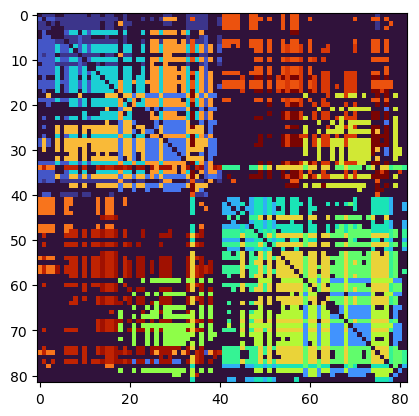

In [39]:
importlib.reload(dgsp)

n_vec_max = 6
n_kmeans = 4

n_vec_max = 4
n_kmeans = None
n_kmeans = 45
n_kmeans = 21

dgsp.edge_bicommunities(graph, U, V, n_vec_max, n_kmeans=None, verbose=True, scale_S=S[:n_vec_max], max_k=30)

C_mat_out, c_pinv_out, C_mat_in, c_pinv_in, bimod_idx, edge_clusters, edge_clusters_mat = dgsp.get_c_pinv(graph, n_vec_max=n_vec_max, n_kmeans=n_kmeans, max_k=70,
                                                                                                          normalize=False, verbose=True, return_clusters=True)

all_mses = np.zeros((2, ntimepoints-2))
all_corrs = np.zeros((2, ntimepoints-2))

all_coefs = np.zeros((2, ntimepoints, n_kmeans))
all_recon = np.zeros((2, ntimepoints-2, n_nodes))

all_prop = np.zeros((2, n_kmeans, ntimepoints, n_nodes))

for t, xt in enumerate(nodal_fmri):
    all_coefs[0, t] = c_pinv_out @ xt
    all_coefs[1, t] = c_pinv_in @ xt

    if t > 0:
        for k in range(n_kmeans):
            k_indicator = (np.arange(n_kmeans) == k).astype(int)
            all_prop[0, k, t] = C_mat_in @ (k_indicator*(c_pinv_in @ nodal_fmri[t]))
            all_prop[1, k, t] = C_mat_out @ (k_indicator*(c_pinv_in @ nodal_fmri[t-1]))
        
        if t < ntimepoints - 1:
            all_recon[0, t-1] = C_mat_out @ (c_pinv_in @ nodal_fmri[t+1])
            all_recon[1, t-1] = C_mat_in @ (c_pinv_out @ nodal_fmri[t-1])


            all_corrs[0, t-1] = pearsonr(all_recon[0, t-1], xt)[0]
            all_corrs[1, t-1] = pearsonr(all_recon[1, t-1], xt)[0]

            all_mses[0, t-1] = np.linalg.norm(all_recon[0, t-1] - xt)/np.linalg.norm(xt)
            all_mses[1, t-1] = np.linalg.norm(all_recon[1, t-1] - xt)/np.linalg.norm(xt)

# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8), gridspec_kw={"wspace":0, "width_ratios": [6, 1]}, sharey="row")

# axes[0, 0].set_ylabel("Correlation", fontsize=16)
# axes[1, 0].set_ylabel("RSE", fontsize=16)

# for ax in axes[:, 1]:
#     ax.axis("off")

# for i, data in enumerate([all_corrs, all_mses]):
#     maxval = np.abs(data).max()
#     for j, d in enumerate(data):
#         axes[i, 0].plot(d, lw=2, alpha=0.8, label=["Send", "Receive"][j])
#         kdeplot(y=d, ax=axes[i, 1], alpha=0.5, linewidth=2, bw_adjust=0.5, fill=True)

# axes[0, 0].set_ylim(-0.74, 0.74)
# for ax in axes[:, 0]:
#     ax.tick_params(labelsize=14)
#     ax.legend(fontsize=14)

plt.imshow(edge_clusters_mat, cmap="turbo", interpolation="none")

# Below is the actual cell where things are happening !

Currently, it's the previous approach where I try to estimate the "switching table" through the pseudoinverse of some weird matrix...

@Deb: I added the updated approach below so that you can play around !

(45, 164)
(1200, 164)


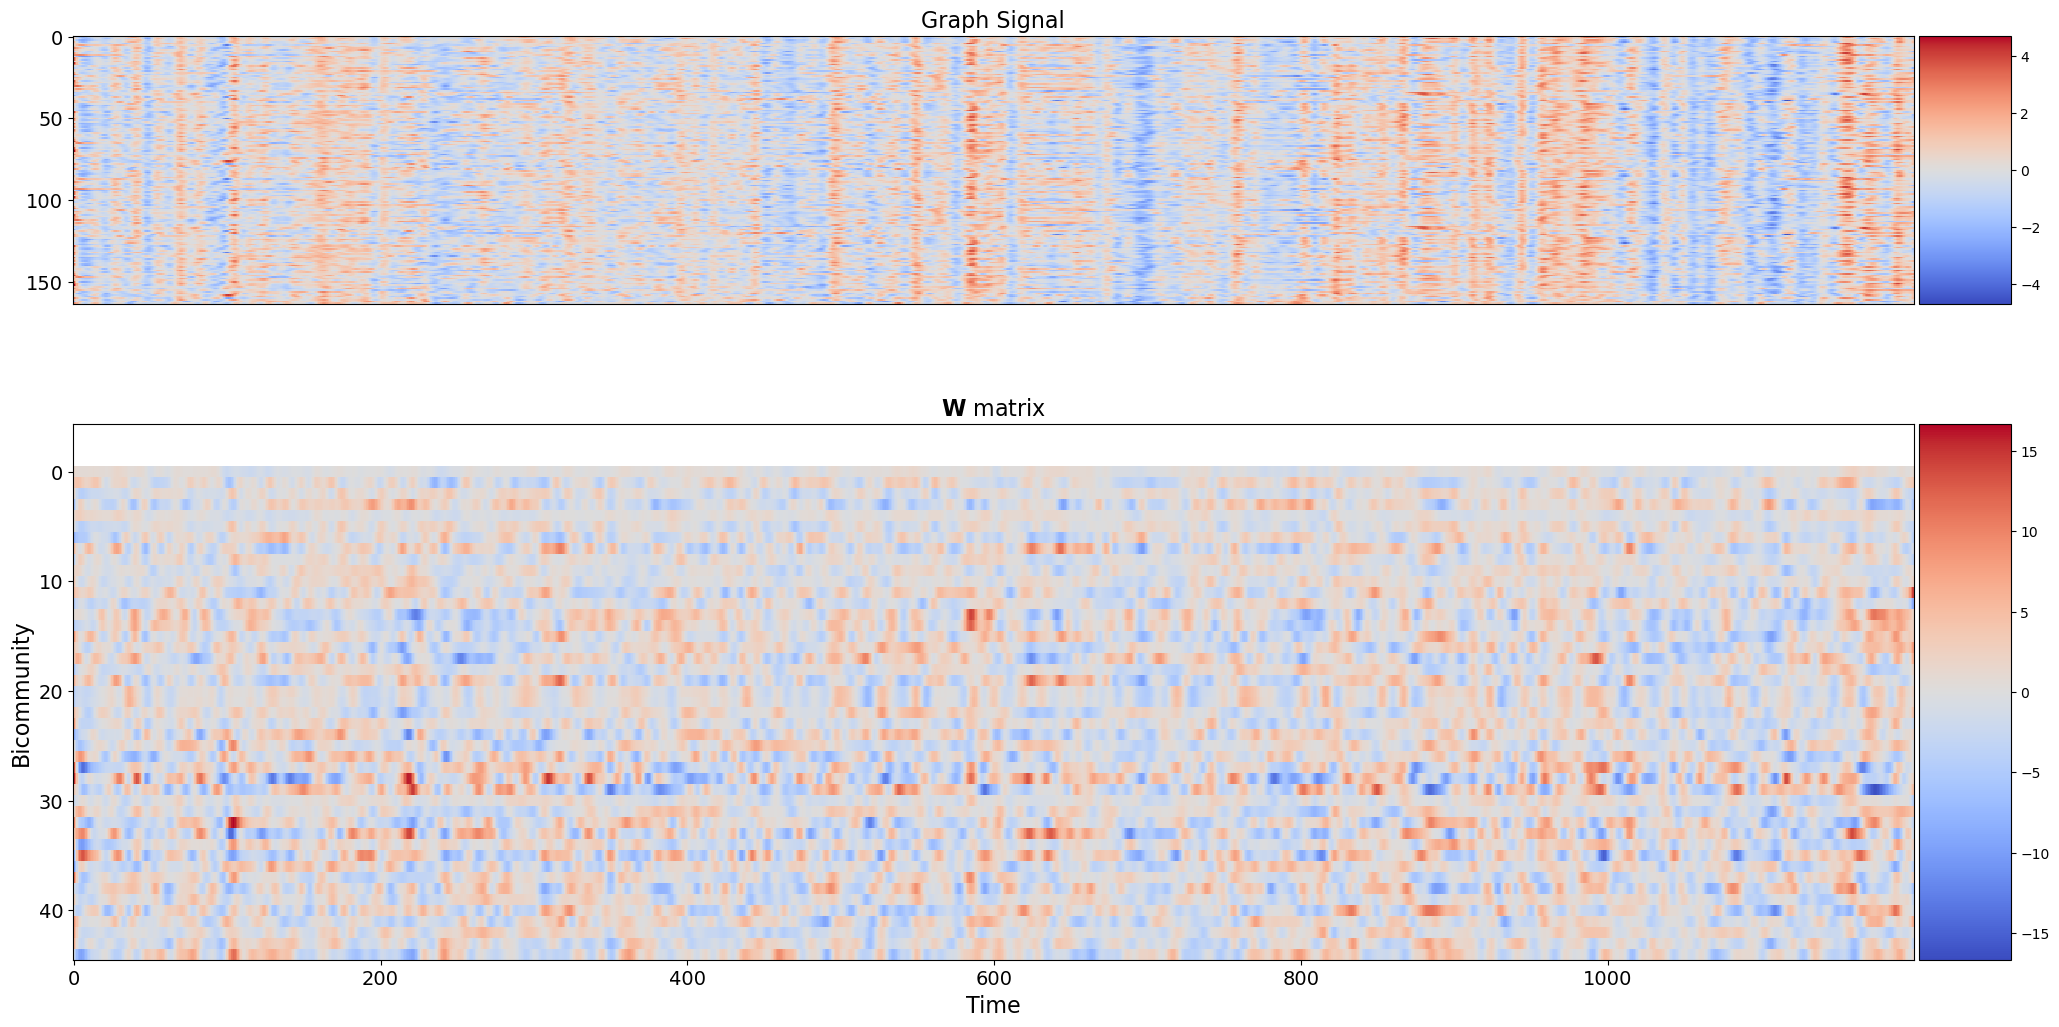

In [41]:
# Define the number of SVD components to consider (look at the spectrum of singular values)
n_vec_max = 4
# Define the number of clusters/communities extracted through k-means
# (you can set this to None with `verbose=True` in `dgsp.get_c_pinv` to see the best number of clusters)
n_kmeans = 45

C_mat_out, c_pinv_out, C_mat_in, c_pinv_in, bimod_idx = dgsp.get_c_pinv(graph, n_vec_max, n_kmeans, normalize=False, verbose=False)

## Updated approach
C_mat = np.concatenate([C_mat_out, C_mat_in])

C_pinv = np.linalg.pinv(C_mat)
print(C_pinv.shape)

# Concatenating x_{t} and x_{t} for each timepoint
x_concat = np.concatenate([nodal_fmri.T, nodal_fmri.T]).T

# Concatenating x_{t} and x_{t} for each timepoint with x_{t} and x_{t+1} in between
# x_concat = np.zeros((2*ntimepoints-1, 2*len(graph)))
# x_concat[::2] = np.concatenate([nodal_fmri.T, nodal_fmri.T]).T
# x_concat[1::2] = np.concatenate([nodal_fmri[:-1].T, nodal_fmri[ 1:].T]).T
print(x_concat.shape)
proj_signals = np.array([C_pinv @ x_t for x_t in x_concat])

fig, axes = plt.subplots(nrows=2, figsize=(25, 12), gridspec_kw={"hspace":0.3, "height_ratios":[1, 2]})

axes[0].set_title("Graph Signal", fontsize=16)
maxval = np.abs(x_concat).max()
axes[0].imshow(x_concat.T, aspect="auto", cmap="coolwarm", interpolation="none", vmin=-maxval, vmax=maxval)

axes[0].set_xticks([])
axes[0].tick_params(labelsize=14)
plot.add_cbar(fig, axes[0])

maxval = proj_signals.max()
minval = -maxval

axes[1].set_title("$\mathbf{W}$ matrix", fontsize=16)
ax = axes[1]
ax.imshow(proj_signals.T, cmap="coolwarm", vmin=minval, vmax=maxval, aspect="auto", interpolation="none")

ax.scatter(np.arange(len(paradygm)-1), [-2]*(len(paradygm)-1), s=20, marker="s",
            c=paradygm[:-1], cmap=para_cmap)

ax.tick_params(labelsize=14)
ax.set_xlabel("Time", fontsize=16)
# ax.set_xlim(-0.9, n_timepoints-1.1)
ax.set_ylabel("Bicommunity", fontsize=16)
_ = plot.add_cbar(fig, ax)

Below is the **old** approach:

In [ ]:
n_vec_max = 4
n_kmeans = 45

C_mat_out, c_pinv_out, C_mat_in, c_pinv_in, bimod_idx = dgsp.get_c_pinv(graph, n_vec_max, n_kmeans, normalize=False, verbose=False)

W_out = (c_pinv_out @ nodal_fmri.T)

b_vectors = np.zeros((n_kmeans, ntimepoints - 1))
for i, w_out in enumerate(W_out.T[:-1]):
    D_mat = C_mat_in @ np.diag(w_out)
    D_pinv = np.linalg.pinv(D_mat, rcond=1e-10)

    b_vectors[:, i] = D_pinv @ nodal_fmri[i+1]

fig, ax = plt.subplots(figsize=(18, 4))

maxval = np.log(b_vectors.max())
minval = -maxval
        
ax.imshow(b_vectors, cmap="turbo", vmin=minval, vmax=maxval, aspect="auto", interpolation="none")

ax.scatter(np.arange(len(paradygm)-1), [-1]*(len(paradygm)-1), s=10, marker="s",
            c=paradygm[:-1], cmap=para_cmap)

if n_kmeans == 12:
    ax.plot([-0.5, ntimepoints-1.5], [n_kmeans//3-0.5, n_kmeans//3-0.5], color="k", lw=2, ls="--")
    ax.plot([-0.5, ntimepoints-1.5], [2*n_kmeans//3-0.5, 2*n_kmeans//3-0.5], color="k", lw=2, ls="--")

ax.tick_params(labelsize=14)
ax.set_xlabel("Time", fontsize=16)
plot.add_cbar(fig, ax)

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 4))

D_mat = C_mat_in @ np.diag(c_pinv_out @ nodal_fmri[0])
D_pinv = np.linalg.pinv(D_mat)
axes[0].imshow(D_mat.T, aspect="auto", cmap="turbo", interpolation="none")
plot.add_cbar(fig, axes[0])

axes[1].imshow(D_pinv, aspect="auto", cmap="turbo", interpolation="none")
plot.add_cbar(fig, axes[1])

In [ ]:
k_residuals = np.zeros((2, n_kmeans, ntimepoints, n_nodes))

for k in range(n_kmeans):
    for t in range(ntimepoints):
        k_residuals[0, k, t] = nodal_fmri[t] - all_prop[0, k, t]
        k_residuals[1, k, t] = nodal_fmri[t] - all_prop[1, k, t]

all_residuals = np.zeros((2, ntimepoints, n_nodes))

all_residuals[0] = [nodal_fmri[t] - all_prop[0, :, t].sum(axis=0) for t in range(ntimepoints)]
all_residuals[1] = [nodal_fmri[t] - all_prop[1, :, t].sum(axis=0) for t in range(ntimepoints)]

all_rse = (np.linalg.norm(all_residuals, axis=-1)/np.linalg.norm(nodal_fmri, axis=-1))
print(all_rse.shape)

all_corrs = np.array([pearsonr(all_residuals[0, t], all_residuals[1, t])[0] for t in range(ntimepoints)])
# all_corrs = np.array([pearsonr(res1, res2)[0] for res1, res2 in zip(all_residuals[0], all_residuals[1])])
print(all_corrs.shape)

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8), gridspec_kw={"wspace":0, "width_ratios": [6, 1]}, sharey="row")

axes[1, 0].set_ylabel("Correlation", fontsize=16)
axes[0, 0].set_ylabel("Residual RSE", fontsize=16)

for ax in axes[:, 1]:
    ax.axis("off")

all_data = [all_rse, [all_corrs, all_corrs]]
labels = ["$C^{{in}}C^{{in\dagger}}\mathbf{{x}}_{{t+1}}$",
          "$C^{{in}}C^{{out\dagger}}\mathbf{{x}}_{{t}}$"]

for i, data in enumerate(all_data):
    maxval = np.abs(data).max()
    for j, d in enumerate(data):
        axes[i, 0].plot(d, lw=2, alpha=0.8, label=labels[j])
        kdeplot(y=d, ax=axes[i, 1], alpha=0.5, linewidth=2, bw_adjust=0.5, fill=True)

    axes[i, 0].scatter(np.arange(len(paradygm)), [0]*len(paradygm), s=20, marker="s",
                       c=paradygm, cmap=para_cmap)

for ax in axes[:, 0]:
    ax.tick_params(labelsize=14)

axes[0, 0].legend(fontsize=14)

In [ ]:
k_rse = (np.linalg.norm(k_residuals, axis=-1)/np.linalg.norm(nodal_fmri, axis=-1))
print(k_rse.shape)

k_corrs = np.zeros((n_kmeans, ntimepoints))
for k in range(n_kmeans):
    for t in range(ntimepoints):
        k_corrs[k, t] = pearsonr(k_residuals[0, k, t], k_residuals[1, k, t])[0]
# all_corrs = np.array([pearsonr(res1, res2)[0] for res1, res2 in zip(all_residuals[0], all_residuals[1])])
print(k_corrs.shape)

In [ ]:
print(k_rse.shape)
print(k_corrs.shape)

fig, axes = plt.subplots(nrows=3, figsize=(18, 6), sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [0.2, 1, 1]})

axes[0].plot(all_corrs, color="k", lw=2)
axes[0].set_yticks([])

axes[0].hlines(0.8, -0.5, ntimepoints-1.5, color="r", lw=1, ls="--")

for i, (ax, val) in enumerate(zip(axes[1:], [k_rse, k_corrs])):
    if i == 0:
        val = val[0] - val[1]
        maxval = val.max()
        minval = -maxval
    else:
        maxval = 1
        minval = 0
        
    ax.imshow(val, cmap="turbo", vmin=minval, vmax=maxval, aspect="auto", interpolation="none")

    ax.scatter(np.arange(len(paradygm)-1), [-0.75]*(len(paradygm)-1), s=10, marker="s",
               c=paradygm[:-1], cmap=para_cmap)

    ax.plot([-0.5, ntimepoints-1.5], [n_kmeans//3-0.5, n_kmeans//3-0.5], color="k", lw=2, ls="--")
    ax.plot([-0.5, ntimepoints-1.5], [2*n_kmeans//3-0.5, 2*n_kmeans//3-0.5], color="k", lw=2, ls="--")

    title = ["Residual RSE", "Correlation"][i]
    ax.set_ylabel(f"{title}", fontsize=16)
    ax.tick_params(labelsize=14)

axes[1].set_xlabel("Time", fontsize=16)

In [ ]:
fig, axes = plt.subplots(nrows=2, figsize=(18, 6), sharex=True, gridspec_kw={"hspace": 0.1})

maxval = np.abs(all_coefs).max()*0.5

for i, (ax, coefs) in enumerate(zip(axes, all_coefs)):
    ax.imshow(coefs.T, cmap="turbo", vmin=-maxval, vmax=maxval, aspect="auto", interpolation="none")

    ax.plot([-0.5, ntimepoints-0.5], [n_kmeans//3-0.5, n_kmeans//3-0.5], color="k", lw=2, ls="--")
    ax.plot([-0.5, ntimepoints-0.5], [2*n_kmeans//3-0.5, 2*n_kmeans//3-0.5], color="k", lw=2, ls="--")

    title = ["Sending", "Receiving"][i]
    ax.set_ylabel(f"{title}\nCoefficients", fontsize=16)
    ax.tick_params(labelsize=14)

axes[1].set_xlabel("Time", fontsize=16)

In [ ]:
fig, ax = plt.subplots(figsize=(18, 5))

# w^{diff}_{t} = w^{out}_{t} - w^{in}_{t-1}
coefs_diff = all_coefs[0, :-1] - all_coefs[1, 1:]
coefs_diff = coefs_diff/coefs_diff.max(axis=0)
# (w^{out}_{t} + w^{in}_{t-1})/2
coefs_avg = (np.abs(all_coefs[0, :-1]) + np.abs(all_coefs[1, 1:]))/2
coefs_avg = coefs_avg/coefs_avg.max(axis=0)

# (1 - w^{diff}_{t}) * w^{avg}_{t}
# 1 if w^{diff}_{t} = 0 and w^{avg}_{t} = 1
# The bigger the difference the smaller the value and the smaller the average the smaller the value
# coefs_cons = (np.abs(coefs_diff).max() - coefs_diff)*coefs_avg
coefs_cons = (1 - coefs_diff)*coefs_avg

maxval = np.abs(coefs_cons).max()
maxval = 1

ntm = ax.imshow(coefs_cons.T, cmap="turbo", vmin=-maxval, vmax=maxval, aspect="auto", interpolation="none")
plt.colorbar(ntm)

ax.plot([-0.5, ntimepoints-1.5], [n_kmeans//3-0.5, n_kmeans//3-0.5], color="k", lw=2, ls="--")
ax.plot([-0.5, ntimepoints-1.5], [2*n_kmeans//3-0.5, 2*n_kmeans//3-0.5], color="k", lw=2, ls="--")

ax.set_xlabel("Time", fontsize=16)
ax.set_ylabel(f"Bicommunity \"Usage\"", fontsize=16)
ax.tick_params(labelsize=14)

for y_para in np.linspace(-1, -0.5, 4):
    ax.scatter(np.arange(len(paradygm)-1), [y_para]*(len(paradygm)-1), s=10, marker="s",
            c=paradygm[:-1], cmap=para_cmap)


In [ ]:
# fig, axes = plt.subplots(figsize=(18, 4), ncols=2, gridspec_kw={"wspace": 0.05, "width_ratios": [4, 1]})
fig, allaxes = plt.subplots(figsize=(18, 10), nrows=2, ncols=2, gridspec_kw={"wspace": 0.05, "hspace":0.3, "width_ratios": [4, 1]})

com_coher = all_coefs[0][:-1] * all_coefs[1][1:]
diff_coher = all_coefs[1][1:] - all_coefs[0][:-1]

coher_titles = [f"Coherency $(\mathbf{{w}}^\\text{{out}}_{{t}}[k]\cdot\mathbf{{w}}^\\text{{in}}_{{t+1}}[k])$",
                f"Coherency $(\mathbf{{w}}^\\text{{in}}_{{t+1}}[k] - \mathbf{{w}}^\\text{{out}}_{{t}}[k])$"]
for ax_i, (axes, coher) in enumerate(zip(allaxes, [com_coher, diff_coher])):

    maxval = np.abs(com_coher).max()*0.9
    maxval = 8
    if ax_i == 0:
        maxval = 10

    axes[0].imshow(coher.T, cmap="turbo", vmin=-maxval, vmax=maxval, aspect="auto", interpolation="none")

    axes[0].plot([-0.5, ntimepoints-1.5], [n_kmeans//3-0.5, n_kmeans//3-0.5], color="k", lw=2, ls="-")
    axes[0].plot([-0.5, ntimepoints-1.5], [2*n_kmeans//3-0.5, 2*n_kmeans//3-0.5], color="k", lw=2, ls="-")

    axes[0].set_title(coher_titles[ax_i], fontsize=16)
    axes[0].set_ylabel(f"Bicommunity $(k)$", fontsize=16)
    axes[0].tick_params(labelsize=14)
    axes[0].set_xlabel("Time", fontsize=16)

    coef_thresh = 0.75
    groups = ["Self", "Within", "Between"]
    colors = ["tab:blue", "tab:orange", "tab:green"]

    axes[1].set_title(f"Top {100*(1-coef_thresh):2.1f}%", fontsize=16)
    axes[1].axis("off")

    gs = GridSpecFromSubplotSpec(3, 1, subplot_spec=axes[1], hspace=0)
    axes_kde = [fig.add_subplot(gs[i]) for i in range(3)]
    y_upper = 0

    if ax_i == 0:
        denom = 3
        max_x = 40
    else:
        denom = 1
        coef_thresh = 1 - coef_thresh
        max_x = 5

    for i in range(3):
        kde_sig = coher[:, 4*i:4*(i+1)].flatten()
        perc_thresh = np.percentile(np.abs(kde_sig), 100*coef_thresh)

        fltr = np.abs(kde_sig) > perc_thresh
        if ax_i > 0:
            fltr = np.abs(kde_sig) < perc_thresh

        whatev = kdeplot(x=kde_sig[fltr], ax=axes_kde[i], alpha=0.4, linewidth=2, bw_adjust=0.5, fill=True, label=groups[i], color=colors[i], clip=(-max_x, max_x))

        ymax = whatev.get_position().bounds[1]
        y_upper = max([ymax, y_upper])

        axes_kde[i].set_yticks([])
        axes_kde[i].set_ylabel("")
        axes_kde[i].set_xlim(-max_x, max_x)
        if i < 2:
            axes_kde[i].set_xticks([])

        axes_kde[i].text(x=0.05, y=0.9, s=groups[i], ha="left", va="top", fontsize=14, transform=axes_kde[i].transAxes)
    axes_kde[-1].tick_params(labelsize=14)

    # for ax in axes_kde:
    #     ax.set_ylim(0, y_upper/denom)

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=12, figsize=(30, 8), gridspec_kw={"wspace":0, "hspace":0}, sharex="row", sharey=True)

axes[0, 0].set_ylabel("Diff. Coherency", fontsize=14)
axes[1, 0].set_ylabel("Diff. Coherency", fontsize=14)

cmap = plt.get_cmap("turbo", ntimepoints)
for k in range(12):

    axes[0, k].set_title(f"\nBicommunity {k+1}", fontsize=16)
    axes[1, k].set_xlabel(f"Coefficients", fontsize=14)

    all_data = np.vstack([all_coefs[0][:-1][:, k], diff_coher[:, k]]).T
    for t, (start, finish) in enumerate(zip(all_data[:-1], all_data[1:])):
        x, y = zip(start, finish)
        axes[0, k].plot(x, y, lw=2, alpha=1, color=cmap(t))
        x = all_coefs[1][:-1][t:t+2, k]
        y = diff_coher[t:t+2, k]
        axes[1, k].plot(x, y, lw=2, alpha=1, color=cmap(t))
        
    # axes[0, k].plot(all_coefs[0][:-1][:, k], diff_coher[:, k], alpha=0.3)
    # axes[1, k].plot(all_coefs[1][1:][:, k], diff_coher[:, k], alpha=0.3)
    # axes[0, k].scatter(all_coefs[0][:-1][:, k], diff_coher[:, k], alpha=0.3, s=20, edgecolor="none", c=np.arange(len(diff_coher[:, k])), cmap="turbo")
    # axes[1, k].scatter(all_coefs[1][1:][:, k], diff_coher[:, k], alpha=0.3, s=20, edgecolor="none", c=np.arange(len(diff_coher[:, k])), cmap="turbo")

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=12, figsize=(30, 8), gridspec_kw={"wspace":0, "hspace":0}, sharex="row", sharey=True)

axes[0, 0].set_ylabel("Prod. Coherency", fontsize=14)
axes[1, 0].set_ylabel("Prod. Coherency", fontsize=14)

cmap = plt.get_cmap("turbo", ntimepoints)
for k in range(12):

    axes[0, k].set_title(f"\nBicommunity {k+1}", fontsize=16)
    axes[1, k].set_xlabel(f"Coefficients", fontsize=14)

    all_data = np.vstack([all_coefs[0][:-1][:, k], com_coher[:, k]]).T
    for t, (start, finish) in enumerate(zip(all_data[:-1], all_data[1:])):
        x, y = zip(start, finish)
        axes[0, k].plot(x, y, lw=2, alpha=1, color=cmap(t))
        x = all_coefs[1][:-1][t:t+2, k]
        y = com_coher[t:t+2, k]
        axes[1, k].plot(x, y, lw=2, alpha=1, color=cmap(t))
        
    # axes[0, k].plot(all_coefs[0][:-1][:, k], diff_coher[:, k], alpha=0.3)
    # axes[1, k].plot(all_coefs[1][1:][:, k], diff_coher[:, k], alpha=0.3)
    # axes[0, k].scatter(all_coefs[0][:-1][:, k], diff_coher[:, k], alpha=0.3, s=20, edgecolor="none", c=np.arange(len(diff_coher[:, k])), cmap="turbo")
    # axes[1, k].scatter(all_coefs[1][1:][:, k], diff_coher[:, k], alpha=0.3, s=20, edgecolor="none", c=np.arange(len(diff_coher[:, k])), cmap="turbo")

In [ ]:
importlib.reload(dgsp)

all_nvecs = [2, 3, 4, 5, 6]
all_kmeans = np.arange(4, 30, 2)

all_mses = np.zeros((len(all_nvecs), len(all_kmeans), 2, ntimepoints-2))
all_corrs = np.zeros((len(all_nvecs), len(all_kmeans), 2, ntimepoints-2))

for n, n_vec_max in enumerate(all_nvecs):
    for k, n_kmeans in enumerate(all_kmeans):
        C_mat_out, c_pinv_out, C_mat_in, c_pinv_in, bimod_idx = dgsp.get_c_pinv(graph, n_vec_max, n_kmeans, normalize=False, verbose=False)

        for t, xt in enumerate(nodal_fmri):
            if (t > 0) and (t < ntimepoints - 1):
                x_sender = C_mat_out @ (c_pinv_in @ nodal_fmri[t+1])
                x_receive = C_mat_in @ (c_pinv_out @ nodal_fmri[t-1])

                all_corrs[n, k, 0, t-1] = pearsonr(x_sender, xt)[0]
                all_corrs[n, k, 1, t-1] = pearsonr(x_receive, xt)[0]

                all_mses[n, k, 0, t-1] = np.linalg.norm(x_sender - xt)/np.linalg.norm(xt)
                all_mses[n, k, 1, t-1] = np.linalg.norm(x_receive - xt)/np.linalg.norm(xt)

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))

maxcor = 0.7
maxerr = 5

for ax in axes.flatten():
    ax.set_xticks(np.arange(len(all_kmeans)), labels=all_kmeans)
    ax.set_yticks(np.arange(len(all_nvecs)), labels=all_nvecs)

# axes[0, 0].imshow(all_corrs[:, :, 0].max(axis=-1), cmap="turbo", vmin=-maxcor, vmax=maxcor)
# axes[1, 0].imshow(all_corrs[:, :, 1].max(axis=-1), cmap="turbo", vmin=-maxcor, vmax=maxcor)

axes[0, 0].imshow(np.percentile(all_corrs[:, :, 0], 90, axis=-1), cmap="turbo", vmin=-maxcor, vmax=maxcor)
axes[1, 0].imshow(np.percentile(all_corrs[:, :, 1], 90, axis=-1), cmap="turbo", vmin=-maxcor, vmax=maxcor)

# axes[0, 1].imshow(all_mses[:, :, 0].mean(axis=-1), cmap="turbo", vmin=0, vmax=3)
# axes[1, 1].imshow(all_mses[:, :, 1].mean(axis=-1), cmap="turbo", vmin=0, vmax=3)

axes[0, 1].imshow(np.percentile(all_mses[:, :, 0], 90, axis=-1), cmap="turbo", vmin=0, vmax=maxerr)
axes[1, 1].imshow(np.percentile(all_mses[:, :, 1], 90, axis=-1), cmap="turbo", vmin=0, vmax=maxerr)

## Multiple Participants

In [ ]:
path_to_fmri = "/Users/acionca/data/HCP-MIP/Laus2008_smth6_lp0.15" # /sub-100307_task-rest_dir-LR_timeseries.csv"

all_fmris = [f for f in os.listdir(path_to_fmri) if ".csv" in f]

all_nodal_fmris = [np.genfromtxt(op.join(path_to_fmri, f), delimiter=",") for f in all_fmris]

for nodal_fmri in all_nodal_fmris:
    print(nodal_fmri.shape)

n_vec_max = 2
n_kmeans = 12

C_mat_out, c_pinv_out, C_mat_in, c_pinv_in, bimod_idx = dgsp.get_c_pinv(graph, n_vec_max, n_kmeans, normalize=False, verbose=False)

In [ ]:
logscale = False

fig, axes = plt.subplots(ncols=len(all_nodal_fmris), figsize=(len(all_nodal_fmris)*5, 5),
                         sharey=True, gridspec_kw={"wspace":0})

for s_i, nodal_fmri in enumerate(all_nodal_fmris):
    print(nodal_fmri.shape)

    ntimepoints = len(nodal_fmri)

    # Coefficients
    all_coefs = np.zeros((2, ntimepoints, n_kmeans))
    all_recon = np.zeros((2, ntimepoints-2, n_nodes))

    for t, xt in enumerate(nodal_fmri):
        all_coefs[0, t] = c_pinv_out @ xt
        all_coefs[1, t] = c_pinv_in @ xt

        if (t > 0) and (t < ntimepoints - 1):
            all_recon[0, t-1] = C_mat_out @ (c_pinv_in @ nodal_fmri[t+1])
            all_recon[1, t-1] = C_mat_in @ (c_pinv_out @ nodal_fmri[t-1])

    # Coherency
    com_coher = all_coefs[0][:-1] * all_coefs[1][1:]
    
    coef_thresh = 0.7
    if logscale:
        coef_thresh = 0
    groups = ["Self", "Within", "Between"]
    colors = ["tab:blue", "tab:orange", "tab:green"]

    for i in range(3):
        kde_sig = com_coher[:, 4*i:4*(i+1)].flatten()
        perc_thresh = np.percentile(np.abs(kde_sig), 100*coef_thresh)
        kdeplot(x=kde_sig[np.abs(kde_sig) > perc_thresh], ax=axes[s_i], alpha=0.4, linewidth=2,
                bw_adjust=0.5, fill=True, label=groups[i], color=colors[i], clip=(-40, 40))

    axes[s_i].set_title("HCP" + all_fmris[s_i].split("_")[0], fontsize=16)
    axes[s_i].set_xlim(-25, 25)
    axes[s_i].tick_params(labelsize=14)
    axes[s_i].legend(fontsize=14, loc="upper left")

    if logscale:
        axes[s_i].set_yscale("log")
        axes[s_i].set_ylim(1e-3, 1)

        axes[s_i].hlines(1e-1, -25, 25, color="k", lw=1, ls="--")
        axes[s_i].hlines(1e-2, -25, 25, color="k", lw=1, ls="--")
    
    axes[s_i].set_xlabel("Coherency", fontsize=16)
    
axes[0].set_ylabel("Density", fontsize=16)